In [140]:
%pylab inline

from scipy import special
import numpy as np
from math import factorial
import biff
from octopus import *
from pygadgetreader import *
from weinberg_method import *


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.4/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['linalg']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [136]:
font = {'size':18, 'family':'serif'}
plt.matplotlib.rc('font', **font)

## How well can the SCF method reproduce a triaxial halo?

1. Compute the Snlm, Tnlm coefficients for oblate and prolate halos.
2. Try to determine 

In [22]:
## Code taken from (https://github.com/adrn/biff/blob/master/notebooks/Plummer%20test.ipynb)
def STnlm(xyz, mass, rs, n_max, l_max):
    nmax = n_max
    lmax = l_max

    Snlm = np.zeros((nmax+1,lmax+1,lmax+1))
    Tnlm = np.zeros((nmax+1,lmax+1,lmax+1))

    nlms = []

    for n in range(nmax+1):
        for l in range(lmax+1):
            for m in range(l+1):
                nlms.append([n,l,m])

    for nlm in nlms:
        n,l,m = nlm
        S,T = biff.compute_coeffs_discrete(np.double(xyz), np.double(mass/100.0), nlm, rs)
        Snlm[n,l,m] = S
        Tnlm[n,l,m] = T
    return Snlm, Tnlm, nlms

In [23]:
def truncate(pos):
    index_cut = np.where(np.sqrt(pos[:,0]**2.0+pos[:,1]**2.0+pos[:,2]**2.0)<500)[0]
    return pos[index_cut]

In [24]:
MW_sph = readsnap('../../data/MW_models/triaxial/spherical_010', 'pos', 'dm')
MW_oblate12 = readsnap('../../data/MW_models/triaxial/Oblate12_010', 'pos', 'dm')
MW_oblate15 = readsnap('../../data/MW_models/triaxial/Oblate15_010', 'pos', 'dm')
MW_prolate06 = readsnap('../../data/MW_models/triaxial/Prolate06_010', 'pos', 'dm')
MW_prolate08 = readsnap('../../data/MW_models/triaxial/Prolate08_010', 'pos', 'dm')
print(len(MW_prolate08))

500000


In [25]:
MW_sph_t = truncate(MW_sph)
MW_oblate12_t = truncate(MW_oblate12)
MW_oblate15_t = truncate(MW_oblate15)
MW_prolate08_t = truncate(MW_prolate08)
MW_prolate06_t = truncate(MW_prolate06)


r_s = 40.85
print(len(MW_prolate08_t))

391910


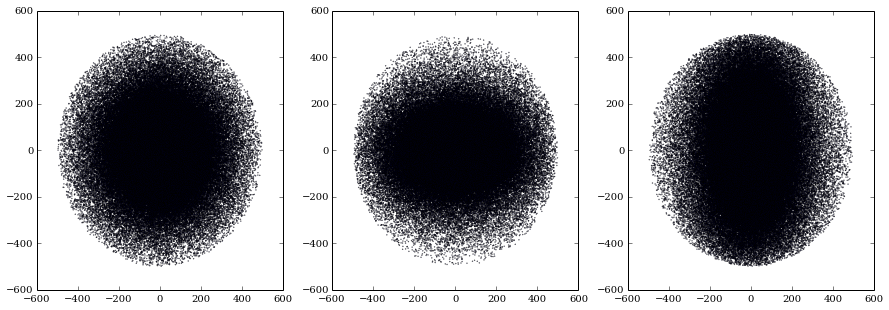

In [126]:
figure(figsize=(15,5))
subplot(1, 3, 1)
scatter(MW_sph_t[:,0], MW_sph_t[:,1], s=0.1)

subplot(1, 3, 2)
scatter(MW_oblate15_t[:,0], MW_oblate15_t[:,2], s=0.1)

subplot(1, 3, 3)
scatter(MW_prolate06_t[:,0], MW_prolate06_t[:,2], s=0.1)

In [146]:
Mass = np.ones(len(MW_sph_t))


In [137]:
Sspheric, Tspheric, nlmsph = STnlm(MW_sph_t, Mass, r_s, 10, 10)
Soblate12, Toblate12, nlmso12 = STnlm(MW_oblate12_t, Mass, r_s, 10, 10)
Soblate15, Toblate15, nlmso15 = STnlm(MW_oblate15_t, Mass, r_s, 10, 10)
Sprolate06, Tprolate06, nlmsp06 = STnlm(MW_prolate06_t, Mass, r_s, 10, 10)
Sprolate08, Tprolate08, nlmsp08 = STnlm(MW_prolate08_t, Mass, r_s, 10, 10)

KeyboardInterrupt: 

\begin{equation}
var(\hat{a}_j) = \dfrac{1}{N}(E[\Psi_j \Psi_j] - E[\Psi_j]E[\Psi_j])
\end{equation}

\begin{equation}
\Psi_{n,l,m} =  m_k \Phi_{n,l}(r_k)Y_{l,m}(\theta_k)cos(m\phi_k)
\end{equation}

In [142]:
def phi_nl_f(r, n, l):
    """
    Input:
    ------
    r: S_nlm, T_nlm coefficients.
    n: Array of particles x-coordiante
    l: Array of particles y-coordiante
    Output:
    -------
    phi_nl: A float number with the variance
    of the coefficient (S_nlm, T_nlm)
    """
    factor = r**l / (1.+r)**(2.*l+1.) * np.sqrt(4.*np.pi)
    s = (r-1.)/(r+1.)
    C_n = special.eval_gegenbauer(n, 2.*l+3./2., r)
    return -factor*C_n

def Anl_f(n,l):
    K_nl = 0.5*n*(n+4.*l+3.) + (l+1.)*(2.*l+1.)
    factor = 2.**(8.*l+6.)/(4.*np.pi*K_nl)
    return -factor*factorial(n)*(n+2*l+3/2.)*(special.gamma(2.*l+3./2.))**2.0/special.gamma(n+4.*l+3.)
    

In [183]:
def coeff_variance(a, x, y, z, mass, n, l, m):
    """
    Input:
    ------
    a: S_nlm, T_nlm coefficients.
    x: Array of particles x-coordiante
    y: Array of particles y-coordiante
    z: Array of particles z-coordinate
    mass: Array with the mass particles
    Output:
    -------
    var(a): A float number with the variance
    of the coefficient (S_nlm, T_nlm)
    """
    r = np.sqrt(x**2.0+y**2.0+z**2.0)
    N = len(r)
    theta = z/r
    phi = np.arctan2(y,x)
    Y_lm = special.sph_harm(m,l,theta,0) # scipy notation m,l
    phi_nl = phi_nl_f(r, n, l)
    Psi = phi_nl*Y_lm*mass*np.cos(m*phi)# Multiply by mass etc..
    if m==0:
        dm0=1.0
    else:
        dm0=0.0
    Anl = Anl_f(n,l)
    variance = ((2.-dm0)*Anl*np.sum(Psi**2.0)) - a**2.0
    S=(2.-dm0)*Anl*np.sum(Psi)
    print(S)
    #print(Anl)
    #print(np.sum(Psi**2.0)*(2.-dm0)*Anl)
    print(a)
    return variance# assuming that all particles have the same mass

In [188]:
#Sspheric[:,:,:]

In [184]:
var_a = np.zeros(2)
for i in range(2):
    var_a[i] = 1/(1+coeff_variance(Sspheric[i,0,0], MW_sph_t[:,0], MW_sph_t[:,1], MW_sph_t[:,0], Mass, i, 0, 0)/Sspheric[i,0,0]**2.0)

(27555.0758928-0j)
3967.96633095


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


(649203.311117-0j)
204.715627809


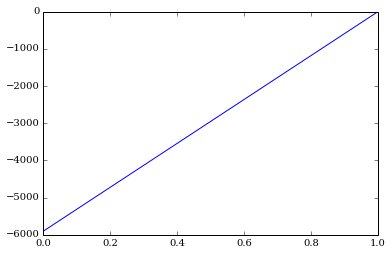

In [182]:
plot((var_a))
#ylim(-40, 10)

In [65]:
#plt.semilogy(np.array(nlmsph)[:0], np.abs(Sspheric[:,0,0].flat/Sspheric[0,0,0])[:], marker='o', c='y', alpha=0.8, label='$n=20$')
#plt.semilogy(np.array(nlmso12)[:,0], np.abs(Soblate12.flat/Soblate12[0,0,0])[:], marker='o', c='k', alpha=0.8, label='$n=20$')
#plt.semilogy(np.array(nlmso15)[:,0], np.abs(Soblate15.flat/Soblate15[0,0,0])[:], marker='o', c='b', alpha=0.8, label='$n=20$')
#plt.semilogy(np.array(nlmsp06)[:,0], np.abs(Sprolate06.flat/Sprolate06[0,0,0])[:], marker='o', c='r', alpha=0.8, label='$n=20$')
#plt.semilogy(np.array(nlmsp08)[:,0], np.abs(Sprolate08.flat/Sprolate08[0,0,0])[:], marker='o', c='g', alpha=0.8, label='$n=20$')

In [93]:
#Sspheric_l, Tsph_l, nlmsph_l = STnlm(MW_sph_t, Mass, r_s, 10, 10)

In [94]:
#Soblate12_l, Toblate12_l, nlmso12_l = STnlm(MW_oblate12_t, Mass, r_s, 10,10)

In [139]:
#Soblate15_l, Toblate15_l, nlmso15_l = STnlm(MW_oblate15_t, Mass, r_s, 10, 10)


In [140]:
#Sprolate06_l, Tprolate06_l, nlmsp06_l = STnlm(MW_prolate06_t, Mass, r_s, 10, 10)
#Sprolate08_l, Tprolate08_l, nlmsp08_l = STnlm(MW_prolate08_t, Mass, r_s, 10, 10)

In [13]:
print Sspheric[:,0,0]

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-13-21b6a888677c>, line 1)

In [15]:
Ssph = Sspheric.flatten()
Sob12 = Soblate12.flatten()
Sob15 = Soblate15.flatten()
Spr06 = Sprolate06.flatten()
Spr08 = Sprolate08.flatten()

"""
Ssph_l = Sspheric_l.flatten()
Sob12_l = Soblate12_l.flatten()
Sob15_l = Soblate15_l.flatten()
Spr06_l = Sprolate06_l.flatten()
Spr08_l = Sprolate08_l.flatten()
"""
#Ssph_all = Ssph_l.flatten()
#Sob12_all = Soblate12_l.flatten()
#Spr06_all = Sprolate06_l.flatten()



'\nSsph_l = Sspheric_l.flatten()\nSob12_l = Soblate12_l.flatten()\nSob15_l = Soblate15_l.flatten()\nSpr06_l = Sprolate06_l.flatten()\nSpr08_l = Sprolate08_l.flatten()\n'

In [18]:
b_sph = smooth_b(Ssph)
b_ob12 = smooth_b(Sob12)
b_ob15 = smooth_b(Sob15)
b_pr06 = smooth_b(Spr06)
b_pr08 = smooth_b(Spr08)

"""
b_sph_l = smooth_b(Ssph_l)
b_ob12_l = smooth_b(Sob12_l)
b_ob15_l = smooth_b(Sob15_l)
b_pr06_l = smooth_b(Spr06_l)
b_pr08_l = smooth_b(Spr08_l)
"""


print(len(b_sph))




180


/home/xozidok/work/github/LMC-MW/code/SCF/weinberg_method.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  b[i] = 1.0/(1.0 + np.var(a)/a[i]**2)


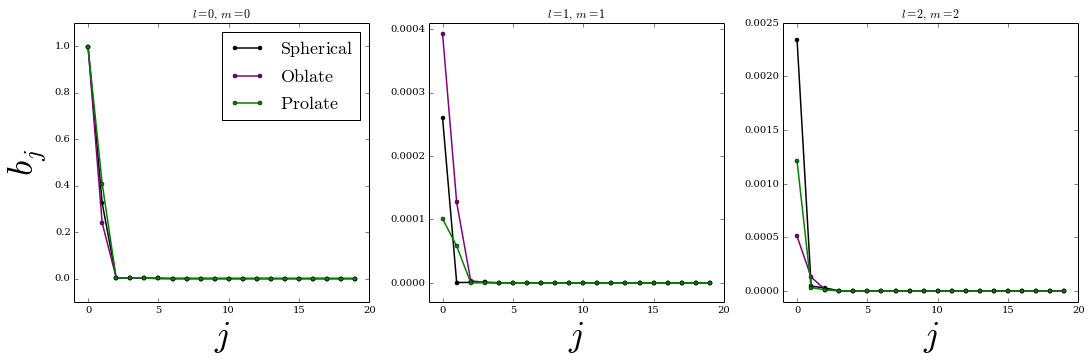

In [19]:
figure(figsize=(18,5))
subplot(1,3,1)
title('$l=0,\ m=0$')
plot(b_sph[0::9], c='k', lw=1.5, marker='o', ms=4, label='$\mathrm{Spherical}$')
plot(b_ob12[0::9], c='purple', lw=1.5, marker='o', ms=4, label='$\mathrm{Oblate}$')
plot(b_pr08[0::9], c='g', lw=1.5, marker='o', ms=4, label='$\mathrm{Prolate}$')
legend(loc='best', fontsize=18)
ylim(-0.1,1.1)
xlim(-1,20)
xlabel('$j$', fontsize=35)
ylabel('$b_j$', fontsize=35)
subplot(1,3,2)
title('$l=1,\ m=1$')
plot(b_sph[4::9], c='k', lw=1.5, marker='o', ms=4)
plot(b_ob12[4::9], c='purple', lw=1.5, marker='o', ms=4)
plot(b_pr08[4::9], c='g', lw=1.5, marker='o', ms=4)
xlim(-1,20)
ylim(-3E-5,4.1E-4)
xlabel('$j$', fontsize=35)

subplot(1,3,3)
title('$l=2,\ m=2$')
plot(b_sph[8::9], c='k', lw=1.5, marker='o', ms=4)
plot(b_ob12[8::9], c='purple', lw=1.5, marker='o', ms=4)
plot(b_pr08[8::9], c='g', lw=1.5, marker='o', ms=4)
xlim(-1,20)
ylim(-1E-4,2.5E-3)
xlabel('$j$', fontsize=35)

In [163]:
print b_pr06_l[0]

1.0


(-10, 1400)

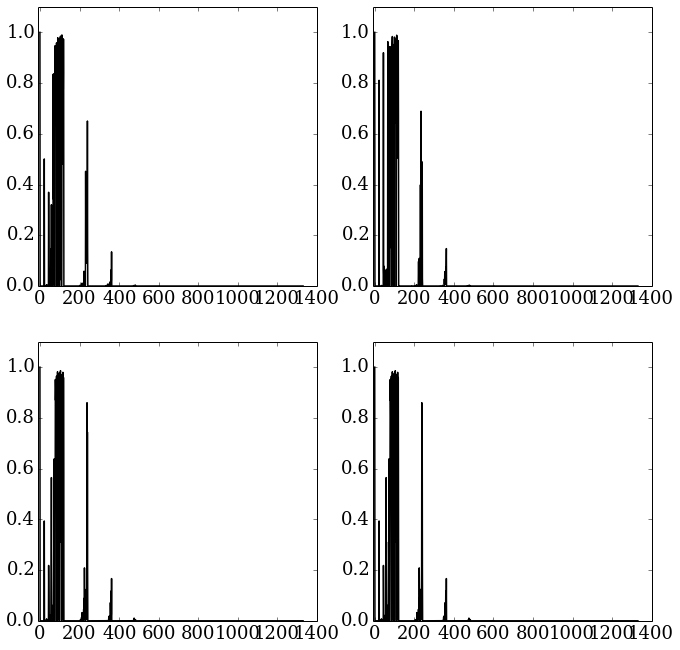

In [168]:
figure(figsize=(11, 11))
subplot(2, 2, 1)
ylim(0,1.1)
xlim(-10,1400)
plot(b_pr08_l, c='k', lw=1.5)
#plot(b_sph_l, alpha=0.5, lw=1.5, c='r')

subplot(2, 2, 2)
plot(b_pr06_l, c='k', lw=1.5)
ylim(0,1.1)
xlim(-10,1400)

subplot(2, 2, 3)
plot(b_ob12_l, c='k', lw=1.5)
ylim(0,1.1)
xlim(-10,1400)

subplot(2, 2, 4)
plot(b_ob12_l, c='k', lw=1.5)
ylim(0,1.1)
xlim(-10,1400)

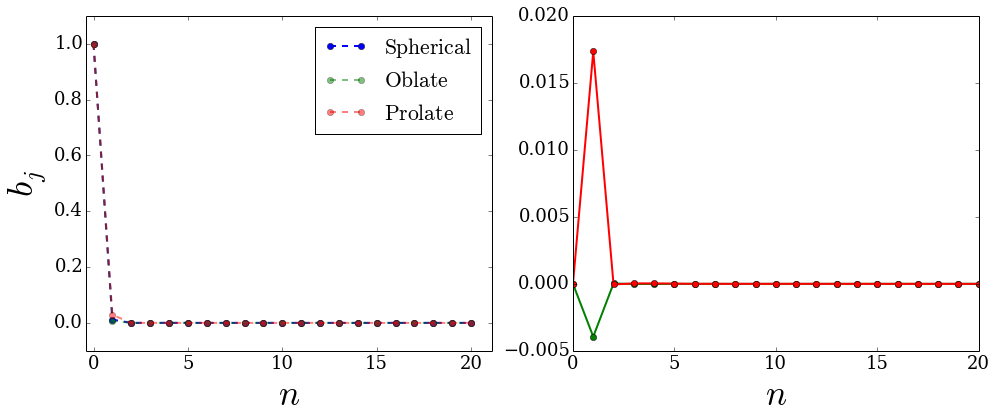

In [48]:
figure(figsize=(16, 6))
subplot(1, 2, 1)

plot(b_sph, ls='--', lw=2, marker='o', label='$\mathrm{Spherical}$')
plot(b_ob12, ls='--', lw=2, marker='o', label='$\mathrm{Oblate}$', alpha=0.5)
plot(b_pr06, ls='--', lw=2, marker='o', label='$\mathrm{Prolate}$', alpha=0.5)
ylabel('$b_j$', fontsize=35)
xlabel('$n$', fontsize=35)

legend(loc='best')

ylim(-0.1, 1.1)
xlim(-0.4, 21.1)

subplot(1, 2, 2)
plot((b_ob12-b_sph), ls='-', lw=2, marker='o', c='g')
plot((b_pr06-b_sph), ls='-', lw=2, marker='o', c='r')
xlabel('$n$', fontsize=35)


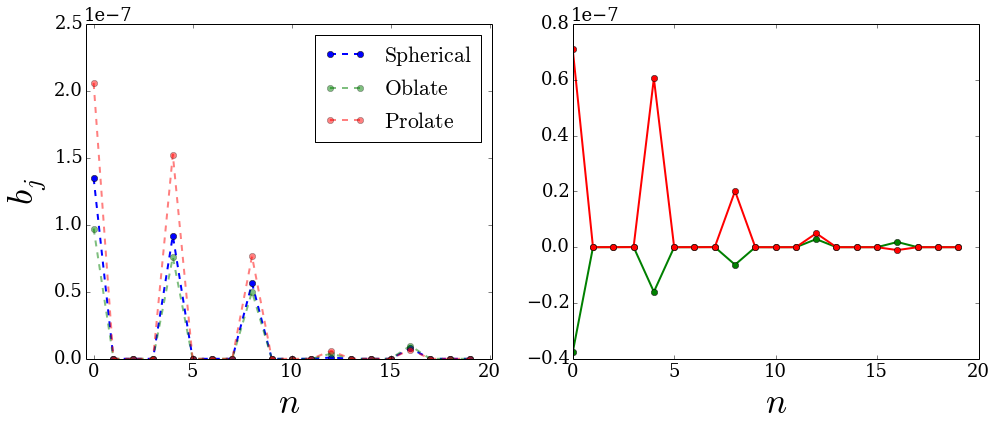

In [51]:
figure(figsize=(16, 6))
subplot(1, 2, 1)

plot(b_sph_l[-20:], ls='--', lw=2, marker='o', label='$\mathrm{Spherical}$')
plot(b_ob12_l[-20:], ls='--', lw=2, marker='o', label='$\mathrm{Oblate}$', alpha=0.5)
plot(b_pr06_l[-20:], ls='--', lw=2, marker='o', label='$\mathrm{Prolate}$', alpha=0.5)
ylabel('$b_j$', fontsize=35)
xlabel('$n$', fontsize=35)

legend(loc='best')

#ylim(-0.1, 1.1)
xlim(-0.4, 20.1)

subplot(1, 2, 2)
plot((b_ob12_l[-20:]-b_sph_l[-20:]), ls='-', lw=2, marker='o', c='g')
plot((b_pr06_l[-20:]-b_sph_l[-20:]), ls='-', lw=2, marker='o', c='r')
xlabel('$n$', fontsize=35)


In [55]:
D_sph_l = MISE(Ssph_l)
D_ob12_l = MISE(Sob12_l)
D_pr06_l = MISE(Spr06_l)

D_sph = MISE(Ssph)
D_ob12 = MISE(Sob12)
D_pr06 = MISE(Spr06)

In [101]:
D = np.zeros(len(Ssph))
D_nb = np.zeros(len(Ssph))
SN = np.zeros(len(Ssph_l))
SN_pr = np.zeros(len(Sob12_l))
for i in range(len(Ssph)):
    D[i] = np.sum(b_sph[:i+1]**2.0 * np.var(Ssph) + (b_sph[:i+1]-1.0)**2.0*Ssph[:i+1]**2.0)
    D_nb[i] = np.sum(np.var(Ssph[:i+1]))
    SN[i] = (Ssph_l[i]**2.0 /np.var(Ssph_l))**0.5
    SN_pr[i] = (Sob12_l[i]**2.0 /np.var(Sob12_l))**0.5

In [127]:
print Sob12_l[:50]
print np.var(Sob12_l), max(Sob12_l)**2.0/np.var(Sob12_l)

[ 4112.43322689     0.             0.             0.             0.             0.
     0.             0.             0.             0.             0.
     6.06094821     6.15063934     0.             0.             0.             0.
     0.             0.             0.             0.             0.
  -689.97067542    -4.73266052    -7.01250786     0.             0.             0.
     0.             0.             0.             0.             0.
   -58.72931212    16.621537      54.33695816    14.52175244     0.             0.
     0.             0.             0.             0.             0.
   326.47027957  -193.03598004    43.73031559   -18.33725256    87.05860088
     0.        ]
62214345.1443 405.791526808


(0, 20)

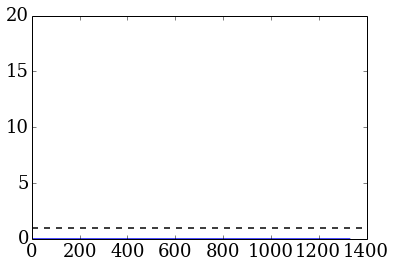

In [128]:
#plot(D)
#plot(D_nb)
#plot(SN[:])
plot(SN_pr)
axhline(1, ls='--', c='k', lw=1.5)
ylim(0,20)

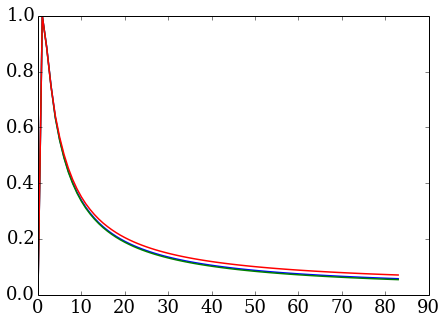

In [61]:
figure(figsize=(7, 5))
#plot(D_sph, lw=1.5)
#plot(D_ob12, lw=1.5)
#plot(D_pr06, lw=1.5)

plot(D_sph_l/max(D_sph_l), lw=1.5)
plot(D_ob12_l/max(D_ob12_l), lw=1.5)
plot(D_pr06_l/max(D_pr06_l), lw=1.5)

#xlim(0, 200)
#ylim(0, 5000000000)

<matplotlib.colorbar.Colorbar instance at 0x7f7176ce6e60>

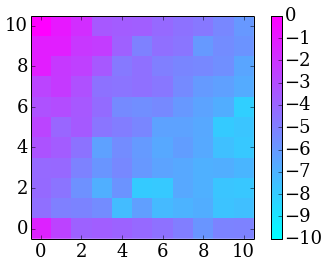

In [36]:
imshow(np.log10(np.abs(Ssph_l[:,:,0]).T / np.nanmax(Ssph_l[:,:,:])), origin='lower', interpolation='None'
           ,cmap = plt.cm.cool, vmin=-10, vmax=0)

colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f71762448c0>

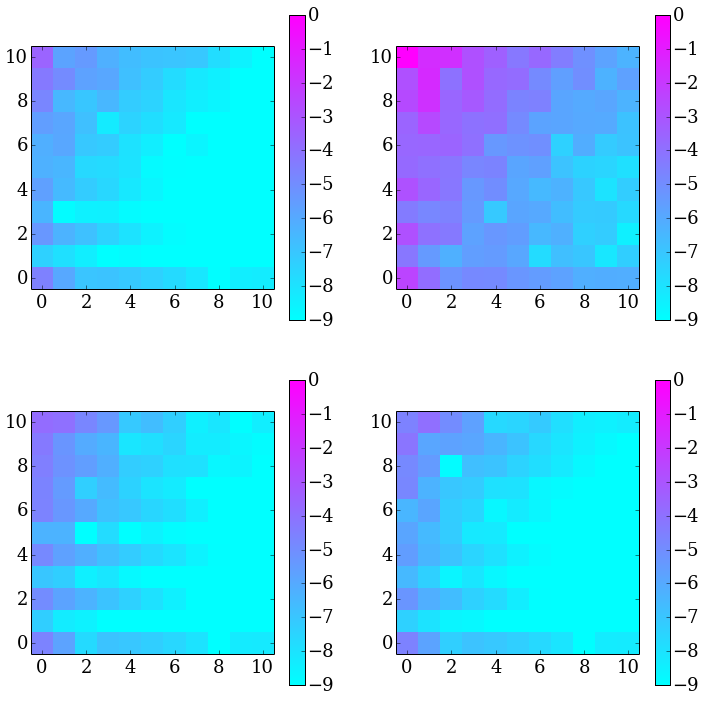

In [37]:
figure(figsize=(12,12))
subplot(2, 2, 1)
imshow(np.log10(np.abs(Soblate12_l[:,:,0]).T / np.nanmax(Soblate15_l[:,:,:])), origin='lower', interpolation='None'
           ,cmap = plt.cm.cool, vmin=-9, vmax=0)
colorbar()

subplot(2, 2, 2)
imshow(np.log10(np.abs(Soblate15_l[:,:,0]).T / np.nanmax(Soblate15_l[:,:,:])), origin='lower', interpolation='None'
           ,cmap = plt.cm.cool, vmin=-9, vmax=0)
colorbar()


subplot(2, 2, 3)
imshow(np.log10(np.abs(Sprolate06_l[:,:,0]).T / np.nanmax(Soblate15_l[:,:,:])), origin='lower', interpolation='None'
           ,cmap = plt.cm.cool, vmin=-9, vmax=0)
colorbar()


subplot(2, 2, 4)
imshow(np.log10(np.abs(Sprolate08_l[:,:,0]).T / np.nanmax(Soblate15_l[:,:,:])), origin='lower', interpolation='None'
           ,cmap = plt.cm.cool, vmin=-9, vmax=0)
colorbar()



In [28]:
## Potentials 

Oblate_12_pos = readsnap('../data/MW_models/triaxial/Oblate12_002.hdf5', 'pos', 'dm')
Oblate_12_pot = readsnap('../data/MW_models/triaxial/Oblate12_002.hdf5', 'pot', 'dm')

Oblate_15_pos = readsnap('../data/MW_models/triaxial/Oblate15_002.hdf5', 'pos', 'dm')
Oblate_15_pot = readsnap('../data/MW_models/triaxial/Oblate15_002.hdf5', 'pot', 'dm')

Prolate_08_pos = readsnap('../data/MW_models/triaxial/Prolate08_002.hdf5', 'pos', 'dm')
Prolate_08_pot = readsnap('../data/MW_models/triaxial/Prolate08_002.hdf5', 'pot', 'dm')

Prolate_06_pos = readsnap('../data/MW_models/triaxial/Prolate06_002.hdf5', 'pos', 'dm')
Prolate_06_pot = readsnap('../data/MW_models/triaxial/Prolate06_002.hdf5', 'pot', 'dm')


(-500, 500)

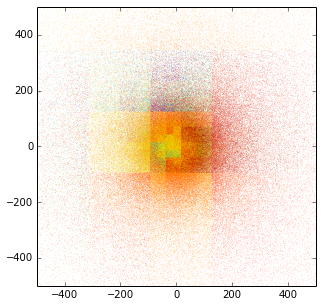

In [12]:
figure(figsize=(5,5))
scatter(Oblate_12_pos[:,0], Oblate_12_pos[:,1], c=np.log10(np.abs(Oblate_15_pot)), edgecolor='none', s=0.1)
xlim(-500,500)
ylim(-500,500)
#colorbar()

In [13]:
def pot_contour(x, y, pot, n_bins):
    x_pot = np.linspace(min(x), max(x), n_bins)
    y_pot = np.linspace(min(y), max(y), n_bins)
    pot_grid = np.zeros((n_bins,  n_bins))

    for i in range(1,n_bins):
        for j in range(1,n_bins):
            index = np.where((x<x_pot[i]) & (x>x_pot[i-1]) & (y<y_pot[j]) & (y>y_pot[j-1]))[0]
            pot_grid[i][j] = np.mean(pot[index])
    return x_pot, y_pot, pot_grid

In [17]:
def trunc(xyz, pot):
    index_cut = np.where(np.sqrt(xyz[:,0]**2.0 + xyz[:,1]**2.0 + xyz[:,2]**2.0) <600)[0]
    return xyz[index_cut], pot[index_cut]

In [29]:
oblate12_t, oblate12_t_pot = trunc(Oblate_12_pos, Oblate_12_pot)
oblate15_t, oblate15_t_pot = trunc(Oblate_15_pos, Oblate_15_pot)

prolate08_t, prolate08_t_pot = trunc(Prolate_08_pos, Prolate_08_pot)
prolate06_t, prolate06_t_pot = trunc(Prolate_06_pos, Prolate_06_pot)

In [45]:
x_prol06, y_prol06, pot_prol06 = pot_contour(prolate06_t[:,0], prolate06_t[:,1], (np.abs(prolate06_t_pot)), 200)
x_prol08, y_prol08, pot_prol08 = pot_contour(prolate08_t[:,0], prolate08_t[:,1], (np.abs(prolate08_t_pot)), 200)

x_obl12, y_obl12, pot_obl12 = pot_contour(oblate12_t[:,0], oblate12_t[:,1], (np.abs(oblate12_t_pot)), 200)
x_obl15, y_obl15, pot_obl15 = pot_contour(oblate15_t[:,0], oblate15_t[:,1], (np.abs(oblate15_t_pot)), 200)

In [43]:
levels1 = np.linspace(np.nanmin(pot_obl12), np.nanmax(pot_obl12), 10)
levels2 = np.linspace(np.nanmin(pot_obl15), np.nanmax(pot_obl15), 10)
levels3 = np.linspace(np.nanmin(pot_prol08), np.nanmax(pot_prol08), 10)
levels4 = np.linspace(np.nanmin(pot_prol06), np.nanmax(pot_prol06), 10)

<matplotlib.contour.QuadContourSet instance at 0x7f35563fe128>

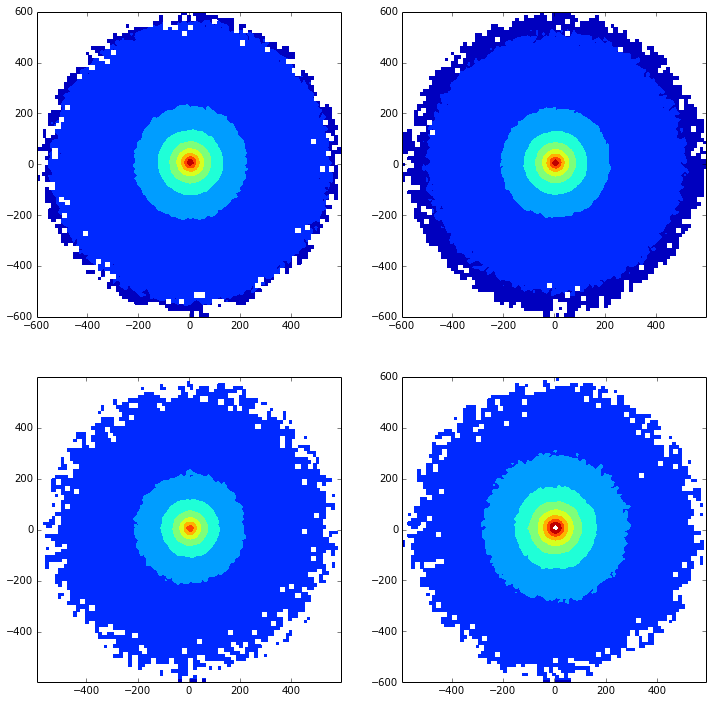

In [44]:
figure(figsize=(12,12))
subplot(2, 2, 1)
contourf(x_obl12, y_obl12, pot_obl12, levels=levels1)

subplot(2, 2, 2)
contourf(x_obl15, y_obl15, pot_obl15, levels=levels2)

subplot(2, 2, 3)
contourf(x_prol06, y_prol06, pot_prol06, levels=levels3)

subplot(2, 2, 4)
contourf(x_prol08, y_prol08, pot_prol08, levels=levels4)